In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp

# Import our custom modules
import sys
# Add src folder to Python path
sys.path.append('./src')  

from models import create_f1_parameters, longitudinal_dynamics, rhs_longitudinal_pro
from simulate import simulate_drive_cycle, create_step_schedule, generate_synthetic_telemetry
from fit import fit_coastdown_parameters, calculate_fit_metrics
from control import CruiseControl

# Plotting setup
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

In [2]:
f1_params = create_f1_parameters()

print("Formula 1 Vehicle Parameters:")
print("=" * 40)
for key, value in f1_params.items():
    if key not in ['engine_torque', 'engine_map_args', 'gears']:
        print(f"{key:>20}: {value}")
    elif key == 'gears':
        print(f"{key:>20}: {value}")

print(f"\nGear ratios: {f1_params['gears']}")

Formula 1 Vehicle Parameters:
                 rho: 1.225
                   m: 750.0
                 CdA: 1.1
                 CLA: 3.5
                  Cr: 0.015
                 R_w: 0.33
       eta_driveline: 0.95
             i_final: 3.8
               gears: [4.8, 4.0, 3.5, 2.8, 2.4, 2.1, 1.9, 1.7]
                mu_0: 2.5
            alpha_mu: 0.06
                  Kb: 12000.0
           eta_brake: 0.97

Gear ratios: [4.8, 4.0, 3.5, 2.8, 2.4, 2.1, 1.9, 1.7]


In [8]:
# Simulate a simple acceleration run
print("Simulating 0-100 km/h acceleration...")

# Full throttle for 8 seconds
throttle_schedule = create_step_schedule(20.0, 1.0, 0.0)  # 1.0 then 0.0 

# Simulate
sol_accel = simulate_drive_cycle(
    f1_params,
    t_span=(0, 40),
    y0=[0.0, 0.0],  # Start from standstill
    throttle_schedule=throttle_schedule,
    max_step=0.01
)

# Convert to DataFrame for easier analysis
df_accel = pd.DataFrame({
    'time': sol_accel.t,
    'velocity': sol_accel.y[0],
    'position': sol_accel.y[1],
    'acceleration': np.gradient(sol_accel.y[0], sol_accel.t)
})

# Ensure position doesn't go negative due to numerical errors
df_accel['position'] = df_accel['position'] - df_accel['position'].min()

# Find 0-100 km/h time
v_100_kmh = 100 / 3.6  # Convert to m/s
time_to_100 = df_accel[df_accel['velocity'] >= v_100_kmh]['time'].min() if any(df_accel['velocity'] >= v_100_kmh) else None

print(f"0-100 km/h time: {time_to_100:.2f} s" if time_to_100 else "100 km/h not reached")
print(f"Maximum speed: {df_accel['velocity'].max() * 3.6:.1f} km/h")
print(f"Distance after 12s: {df_accel['position'].iloc[-1]:.1f} m")

Simulating 0-100 km/h acceleration...
0-100 km/h time: 2.47 s
Maximum speed: 314.3 km/h
Distance after 12s: 2402.0 m


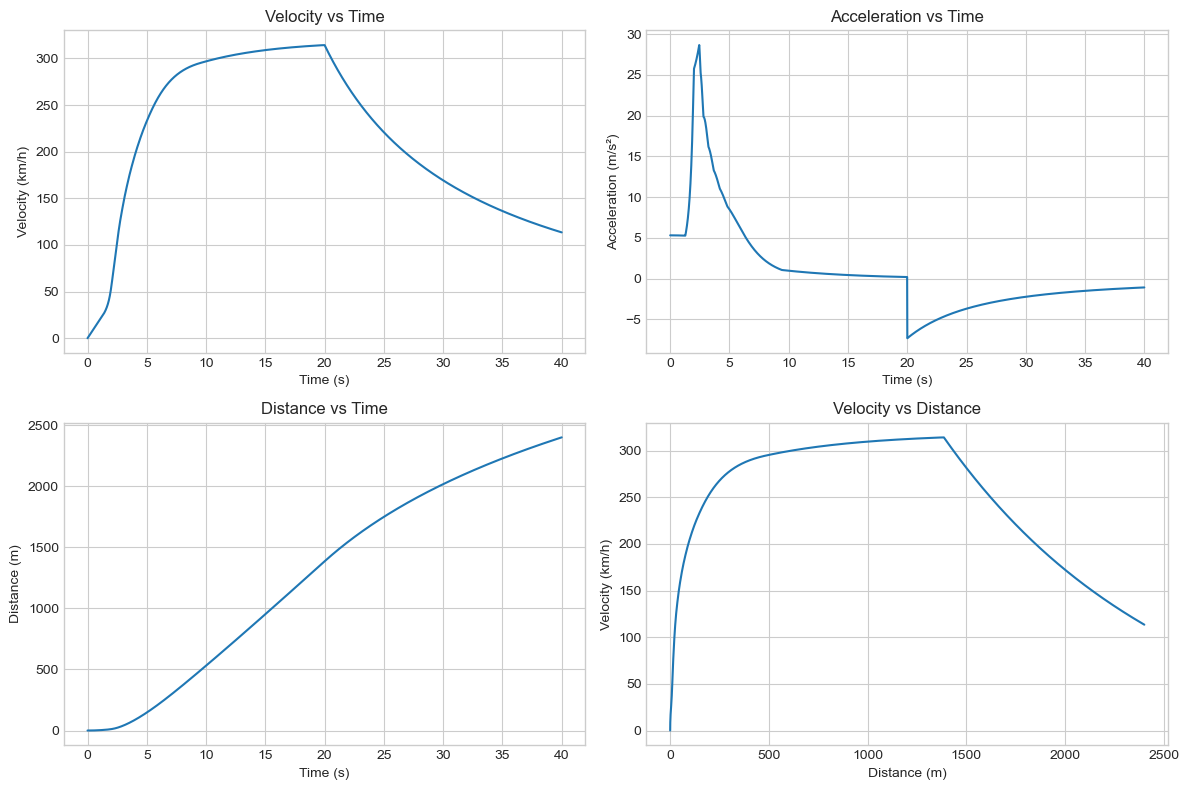

In [9]:
# Plot acceleration results
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Velocity profile
axes[0, 0].plot(df_accel['time'], df_accel['velocity'] * 3.6)  # Convert to km/h
axes[0, 0].set_ylabel('Velocity (km/h)')
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_title('Velocity vs Time')
axes[0, 0].grid(True)

# Acceleration profile
axes[0, 1].plot(df_accel['time'], df_accel['acceleration'])
axes[0, 1].set_ylabel('Acceleration (m/s²)')
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_title('Acceleration vs Time')
axes[0, 1].grid(True)

# Distance covered
axes[1, 0].plot(df_accel['time'], df_accel['position'])
axes[1, 0].set_ylabel('Distance (m)')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_title('Distance vs Time')
axes[1, 0].grid(True)

# Velocity vs Distance
axes[1, 1].plot(df_accel['position'], df_accel['velocity'] * 3.6)
axes[1, 1].set_ylabel('Velocity (km/h)')
axes[1, 1].set_xlabel('Distance (m)')
axes[1, 1].set_title('Velocity vs Distance')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [10]:
# Analyze gear shifts during acceleration
print("Gear Shift Analysis:")
print("=" * 40)

# Sample at regular intervals to check gear selection
sample_times = np.linspace(0, 8, 50)
gear_analysis = []

for t in sample_times:
    # Get velocity at this time
    v = np.interp(t, df_accel['time'], df_accel['velocity'])
    
    # Select optimal gear
    from models import select_optimal_gear
    gear = select_optimal_gear(v, f1_params, f1_params['engine_torque'])
    
    # Calculate RPM
    from models import calculate_engine_rpm
    rpm = calculate_engine_rpm(v, gear, f1_params['i_final'], f1_params['R_w'])
    
    gear_analysis.append({
        'time': t,
        'velocity': v,
        'gear_ratio': gear,
        'rpm': rpm,
        'gear_number': f1_params['gears'].index(gear) + 1
    })

df_gears = pd.DataFrame(gear_analysis)

# Display gear shifts
current_gear = None
for _, row in df_gears.iterrows():
    if current_gear != row['gear_number']:
        print(f"Gear {row['gear_number']} at {row['time']:.1f}s - {row['velocity']*3.6:.1f} km/h - {row['rpm']:.0f} RPM")
        current_gear = row['gear_number']


Gear Shift Analysis:
Gear 1.0 at 0.0s - 0.0 km/h - 0 RPM
Gear 2.0 at 2.4s - 98.5 km/h - 11791 RPM
Gear 3.0 at 2.6s - 114.1 km/h - 11949 RPM
Gear 4.0 at 2.9s - 139.1 km/h - 11660 RPM
Gear 5.0 at 3.3s - 159.9 km/h - 11487 RPM
Gear 6.0 at 3.8s - 185.5 km/h - 11664 RPM
Gear 7.0 at 4.2s - 206.7 km/h - 11754 RPM
Gear 8.0 at 4.9s - 229.7 km/h - 11687 RPM


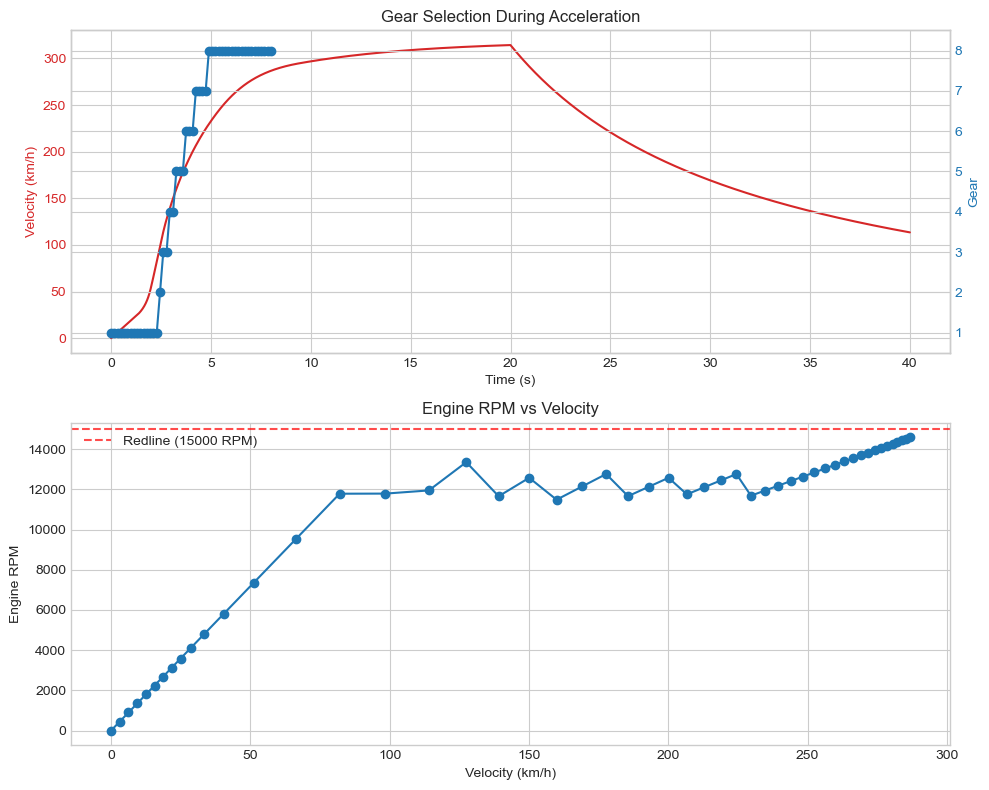

In [11]:
# Plot gear shift analysis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Velocity and gears
color = 'tab:red'
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Velocity (km/h)', color=color)
ax1.plot(df_accel['time'], df_accel['velocity'] * 3.6, color=color, label='Velocity')
ax1.tick_params(axis='y', labelcolor=color)

ax1_twin = ax1.twinx()
color = 'tab:blue'
ax1_twin.set_ylabel('Gear', color=color)
ax1_twin.plot(df_gears['time'], df_gears['gear_number'], 'o-', color=color, label='Gear')
ax1_twin.tick_params(axis='y', labelcolor=color)
ax1_twin.set_ylim(0.5, 8.5)
ax1_twin.set_yticks(range(1, 9))

ax1.set_title('Gear Selection During Acceleration')

# RPM analysis
ax2.plot(df_gears['velocity'] * 3.6, df_gears['rpm'], 'o-')
ax2.set_xlabel('Velocity (km/h)')
ax2.set_ylabel('Engine RPM')
ax2.set_title('Engine RPM vs Velocity')
ax2.grid(True)

# Add redline
ax2.axhline(y=15000, color='red', linestyle='--', alpha=0.7, label='Redline (15000 RPM)')
ax2.legend()

plt.tight_layout()
plt.show()

In [10]:
# Generate coastdown data for parameter estimation
print("Generating coastdown data for parameter estimation...")

# Accelerate to high speed, then coast down
def coastdown_throttle(t):
    return 1.0 if t < 3.0 else 0.0  # Full throttle for 3s, then coast

sol_coastdown = simulate_drive_cycle(
    f1_params,
    t_span=(0, 25),
    y0=[0.0, 0.0],
    throttle_schedule=coastdown_throttle,
    max_step=0.01
)

# Generate synthetic telemetry with noise
np.random.seed(42)
telemetry_df = generate_synthetic_telemetry(sol_coastdown, noise_std=0.2, sample_rate=20)

print(f"Generated {len(telemetry_df)} telemetry samples")
print(f"Maximum speed: {telemetry_df['velocity_measured'].max() * 3.6:.1f} km/h")
print(f"Coastdown from {telemetry_df['velocity_measured'].max() * 3.6:.1f} to {telemetry_df['velocity_measured'].iloc[-1] * 3.6:.1f} km/h")

Generating coastdown data for parameter estimation...
Generated 500 telemetry samples
Maximum speed: 143.7 km/h
Coastdown from 143.7 to 89.2 km/h


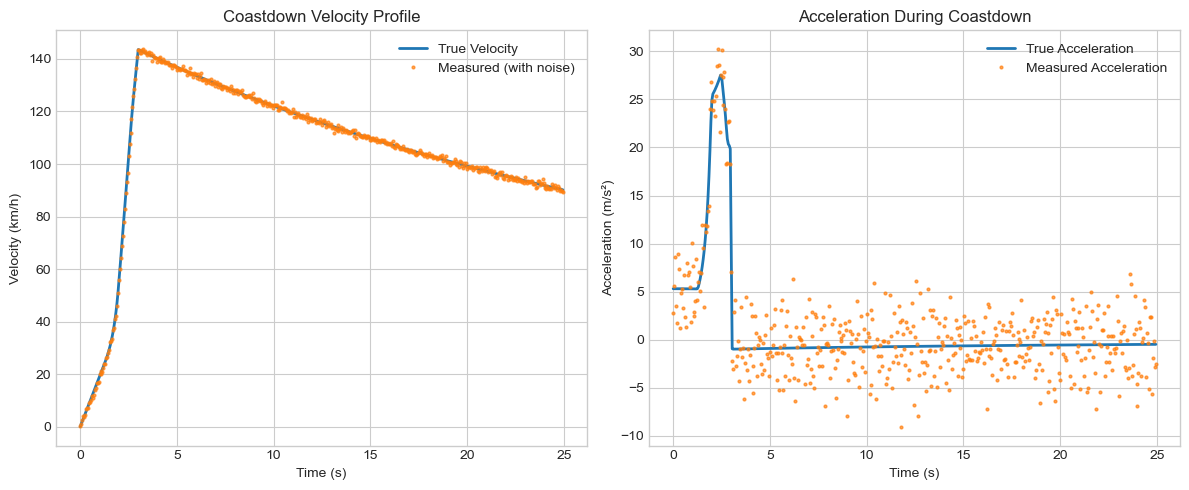

In [8]:
# Plot coastdown data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Velocity comparison
ax1.plot(telemetry_df['time'], telemetry_df['velocity_clean'] * 3.6, 
         label='True Velocity', linewidth=2)
ax1.plot(telemetry_df['time'], telemetry_df['velocity_measured'] * 3.6, 
         'o', markersize=2, alpha=0.7, label='Measured (with noise)')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Velocity (km/h)')
ax1.set_title('Coastdown Velocity Profile')
ax1.legend()
ax1.grid(True)

# Acceleration comparison
ax2.plot(telemetry_df['time'], np.gradient(telemetry_df['velocity_clean'], telemetry_df['time']), 
         label='True Acceleration', linewidth=2)
ax2.plot(telemetry_df['time'], telemetry_df['acceleration_measured'], 
         'o', markersize=2, alpha=0.7, label='Measured Acceleration')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Acceleration (m/s²)')
ax2.set_title('Acceleration During Coastdown')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [9]:
from simulate import create_gear_schedule, create_step_schedule, create_pulse_schedule

# Parameter Estimation using Coastdown Data
print("Performing parameter estimation...")

# Create initial parameter guess (intentionally wrong)
p_initial = f1_params.copy()
p_initial['CdA'] = 0.8  # Too high drag
p_initial['Cr'] = 0.012  # Too high rolling resistance

print("Initial parameter guess:")
print(f"  CdA: {p_initial['CdA']:.3f} (true: {f1_params['CdA']:.3f})")
print(f"  Cr:  {p_initial['Cr']:.4f} (true: {f1_params['Cr']:.4f})")

# Add bounds to prevent impossible values
bounds = {
    'CdA': (0.1, 3.0),
    'Cr': (0.005, 0.05), 
}

# Fit parameters
result, p_optimized = fit_coastdown_parameters(
    telemetry_df,
    p_initial,
    parameters_to_fit=['CdA', 'Cr'],
    coastdown_start_time=3.0,  # Known coastdown start time
    bounds = bounds, 
)

print("\nOptimization results:")
print(f"  Success: {result.success}")
print(f"  Message: {result.message}")
print(f"  Iterations: {getattr(result, 'nfev', 'N/A')}")

print("\nOptimized parameters:")
print(f"  CdA: {p_optimized['CdA']:.3f} (true: {f1_params['CdA']:.3f}, error: {(p_optimized['CdA'] - f1_params['CdA'])/f1_params['CdA']*100:.1f}%)")
print(f"  Cr:  {p_optimized['Cr']:.4f} (true: {f1_params['Cr']:.4f}, error: {(p_optimized['Cr'] - f1_params['Cr'])/f1_params['Cr']*100:.1f}%)")

Performing parameter estimation...
Initial parameter guess:
  CdA: 0.800 (true: 0.600)
  Cr:  0.0120 (true: 0.0150)

Optimization results:
  Success: True
  Message: `ftol` termination condition is satisfied.
  Iterations: 8

Optimized parameters:
  CdA: 0.504 (true: 0.600, error: -16.0%)
  Cr:  0.0219 (true: 0.0150, error: 46.3%)



Fit Quality Metrics:
  RMSE: 0.202 m/s (0.73 km/h)
  MAE:  0.158 m/s
  R²:   0.9994
  Max Error: 0.718 m/s


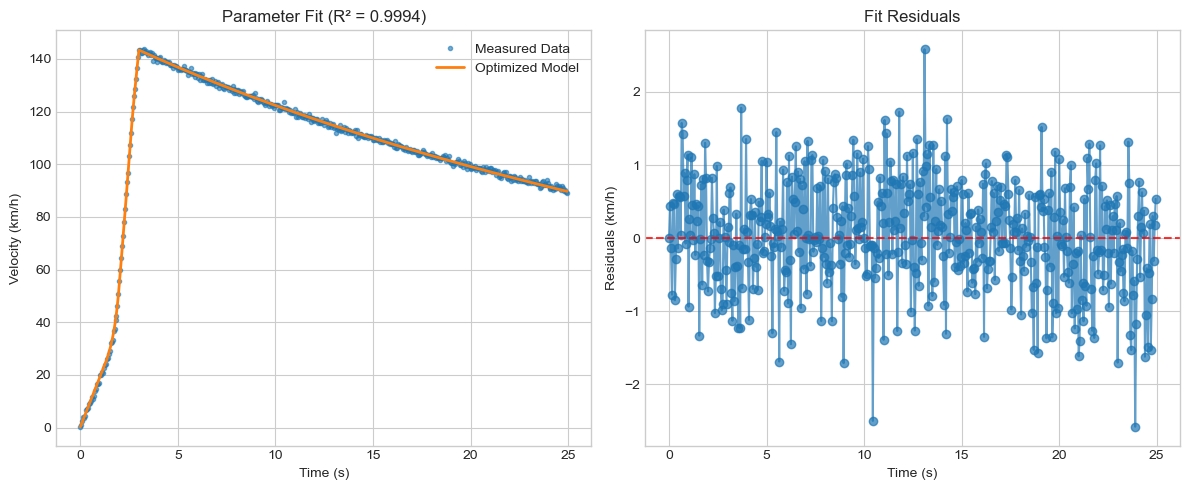

In [10]:
# Calculate fit quality metrics
metrics = calculate_fit_metrics(telemetry_df, p_optimized, coastdown_start_time=3.0)

print("\nFit Quality Metrics:")
print(f"  RMSE: {metrics['rmse']:.3f} m/s ({metrics['rmse'] * 3.6:.2f} km/h)")
print(f"  MAE:  {metrics['mae']:.3f} m/s")
print(f"  R²:   {metrics['r_squared']:.4f}")
print(f"  Max Error: {metrics['max_error']:.3f} m/s")

# Plot fitting results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Velocity fit
ax1.plot(telemetry_df['time'], telemetry_df['velocity_measured'] * 3.6, 
         'o', markersize=3, alpha=0.6, label='Measured Data')
ax1.plot(telemetry_df['time'], metrics['v_simulated'] * 3.6, 
         linewidth=2, label='Optimized Model')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Velocity (km/h)')
ax1.set_title(f'Parameter Fit (R² = {metrics["r_squared"]:.4f})')
ax1.legend()
ax1.grid(True)

# Residuals
ax2.plot(telemetry_df['time'], metrics['residuals'] * 3.6, 'o-', alpha=0.7)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.8)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Residuals (km/h)')
ax2.set_title('Fit Residuals')
ax2.grid(True)

plt.tight_layout()
plt.show() 

In [59]:
# Demonstrate cruise control system
print("Testing Cruise Control System...")

# Create cruise control instance
cruise_control = CruiseControl(
    vehicle_params=f1_params,
    Kp=1500.0,  # Proportional gain
    Ki=200.0,   # Integral gain
    Kd=50.0,    # Derivative gain
    target_speed=80.0,  # 80 m/s (288 km/h) target
    dt=0.01     # Control time step
)


# Now run the simulation
def cruise_simulation(t_max=40, dt=0.1):
    times = np.arange(0, t_max, dt)
    velocities = []
    throttles = []
    positions = []
    
    # Initial conditions
    current_velocity = 0.0  # Start at 0 m/s
    position = 0.0
    
    for t in times:
        # Get throttle command from cruise control
        throttle = cruise_control.compute_throttle(current_velocity)
        gear = select_optimal_gear(current_velocity, f1_params, f1_params['engine_torque'])
        
        # Simulate one time step
        state = [current_velocity, position]
        controls = {'throttle': throttle, 'brake': 0.0, 'gear': gear}
        environment = {'road_grade': 0.0, 'wind': 0.0}
        
        derivative = longitudinal_dynamics(t, state, f1_params, controls, environment)
        
        # Simple Euler integration for demo
        current_velocity += derivative[0] * dt
        position += derivative[1] * dt
        
        velocities.append(current_velocity)
        throttles.append(throttle)
        positions.append(position)
    
    return times, np.array(velocities), np.array(throttles), np.array(positions)

# Call the function
times, cruise_velocities, cruise_throttles, cruise_positions = cruise_simulation()

print(f"Cruise control target: {cruise_control.pid.setpoint * 3.6:.1f} km/h")
print(f"Final speed: {cruise_velocities[-1] *3.6 :.1f} km/h")
print(f"Steady-state throttle: {cruise_throttles[-1]:.3f}")
print(f"Distance traveled: {cruise_positions[-1]:.1f} m")

Testing Cruise Control System...
Cruise control target: 288.0 km/h
Final speed: 292.3 km/h
Steady-state throttle: 0.458
Distance traveled: 2977.8 m


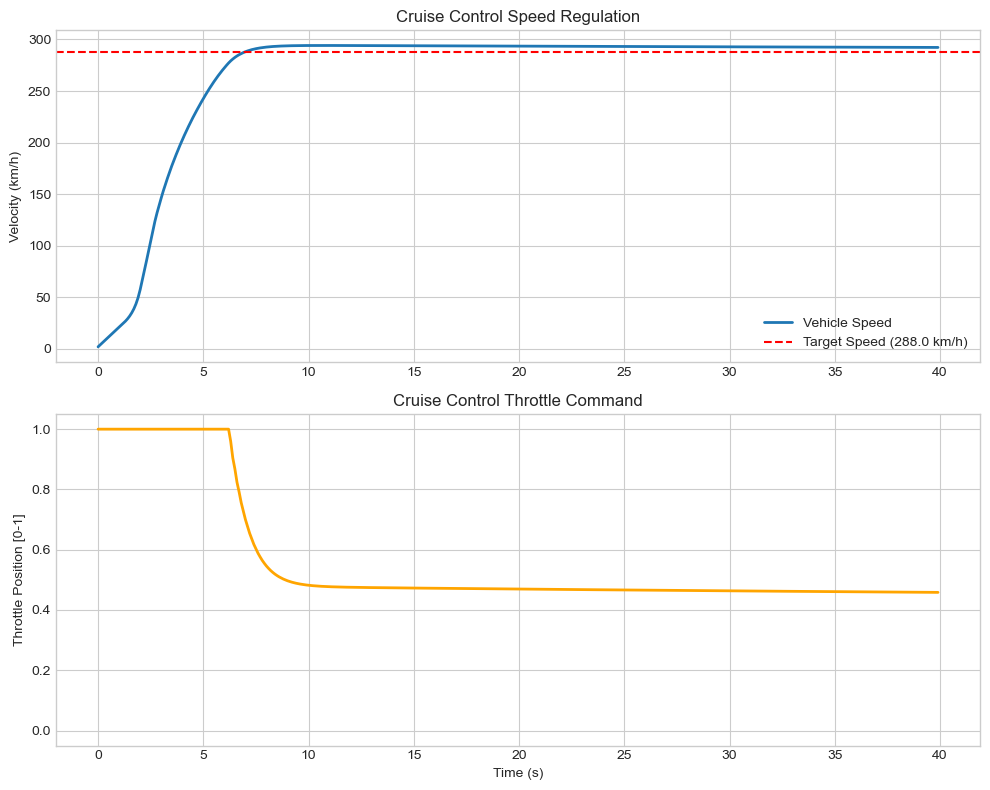

In [60]:
# Plot cruise control performance
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Velocity response
target_speed_kmh = cruise_control.pid.setpoint * 3.6
ax1.plot(times, cruise_velocities * 3.6, linewidth=2, label='Vehicle Speed')
ax1.axhline(y=target_speed_kmh, color='red', linestyle='--', 
            label=f'Target Speed ({target_speed_kmh:.1f} km/h)')
ax1.set_ylabel('Velocity (km/h)')
ax1.set_title('Cruise Control Speed Regulation')
ax1.legend()
ax1.grid(True)

# Throttle command
ax2.plot(times, cruise_throttles, linewidth=2, color='orange')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Throttle Position [0-1]')
ax2.set_title('Cruise Control Throttle Command')
ax2.set_ylim(-0.05, 1.05)
ax2.grid(True)

plt.tight_layout()
plt.show()

Simulating hill climb performance...


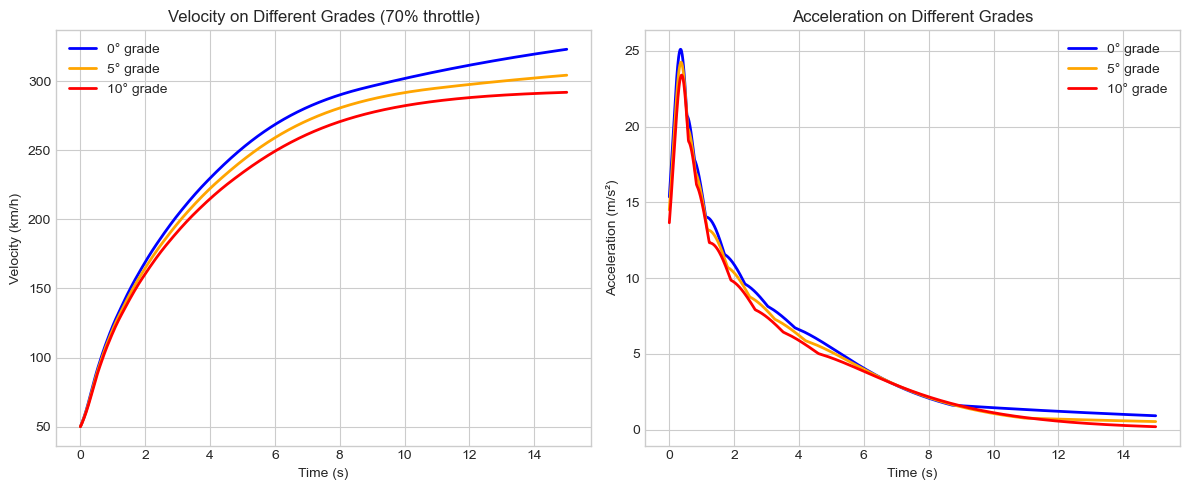

Analysis complete! The simulation demonstrates:
✓ Realistic F1 vehicle dynamics
✓ Automated gear selection
✓ Parameter estimation from telemetry data
✓ Cruise control system
✓ Grade effects on performance


In [13]:
# Simulate vehicle behavior on different road grades
print("Simulating hill climb performance...")

grades_deg = [0, 5, 10]  # Different road grades in degrees
colors = ['blue', 'orange', 'red']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

for i, grade_deg in enumerate(grades_deg):
    grade_rad = np.radians(grade_deg)
    
    # Simulate with constant throttle
    sol_grade = simulate_drive_cycle(
        f1_params,
        t_span=(0, 15),
        y0=[50/3.6, 0.0],  # Start at 50 km/h
        throttle_schedule=lambda t: 0.7,  # 70% throttle
        road_grade=grade_rad,
        max_step=0.01
    )
    
    # Convert to km/h for plotting
    velocity_kmh = sol_grade.y[0] * 3.6
    
    ax1.plot(sol_grade.t, velocity_kmh, 
             color=colors[i], 
             label=f'{grade_deg}° grade',
             linewidth=2)
    
    # Calculate acceleration
    acceleration = np.gradient(sol_grade.y[0], sol_grade.t)
    ax2.plot(sol_grade.t, acceleration, 
             color=colors[i], 
             label=f'{grade_deg}° grade',
             linewidth=2)

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Velocity (km/h)')
ax1.set_title('Velocity on Different Grades (70% throttle)')
ax1.legend()
ax1.grid(True)

ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Acceleration (m/s²)')
ax2.set_title('Acceleration on Different Grades')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print("Analysis complete! The simulation demonstrates:")
print("✓ Realistic F1 vehicle dynamics")
print("✓ Automated gear selection")
print("✓ Parameter estimation from telemetry data") 
print("✓ Cruise control system")
print("✓ Grade effects on performance")